In [1]:
import json
import random
from collections import defaultdict
from rendering_utils import *

## Model-based vs Model-free

Model-based reinforcement learning need to **know the model**; in particular, we have access to $P_a(s' \mid s)$ and $r(s,a,s')$.

While in model-free reinforcement learning, we don't know the transitions and the rewards?!* We **learn through experience** by trying actions and seeing what the results is, making this machine learning problem.

In [2]:
class MDP:
    """Return all states of this MDP"""

    def get_states(self):
        pass

    """ Return all actions with non-zero probability from this state """

    def get_actions(self, state):
        pass

    """ Return all non-zero probability transitions for this action
        from this state, as a list of (state, probability) pairs
    """

    def get_transitions(self, state, action):
        pass

    """ Return the reward for transitioning from state to
        nextState via action
    """

    def get_reward(self, state, action, next_state):
        pass

    """ Return true if and only if state is a terminal state of this MDP """

    def is_terminal(self, state):
        pass

    """ Return the discount factor for this MDP """

    def get_discount_factor(self):
        pass

    """ Return the initial state of this MDP """

    def get_initial_state(self):
        pass

    """ Return all goal states of this MDP """

    def get_goal_states(self):
        pass

    """ Return a new state and a reward for executing action in state,
    based on the underlying probability. This can be used for
    model-free learning methods, but requires a model to operate.
    Override for simulation-based learning
    """

    def execute(self, state, action):
        rand = random.random()
        cumulative_probability = 0.0
        for (new_state, probability) in self.get_transitions(state, action):
            if cumulative_probability <= rand <= probability + cumulative_probability:
                reward = self.get_reward(state, action, new_state)
                return (new_state, reward, self.is_terminal(new_state))
            cumulative_probability += probability
            if cumulative_probability >= 1.0:
                raise (
                    "Cumulative probability >= 1.0 for action "
                    + str(action)
                    + " from "
                    + str(state)
                )

        raise BaseException(
            "No outcome state in simulation for action "
            + str(action)
            + " from "
            + str(state)
        )

    """ 
    Execute a policy on this mdp for a number of episodes.
    """

    def execute_policy(self, policy, episodes=100, max_step=100):
        cumulative_rewards = []
        states = set()
        for _ in range(episodes):
            cumulative_reward = 0.0
            state = self.get_initial_state()
            step = 0
            while not self.is_terminal(state):
                actions = self.get_actions(state)
                action = policy.select_action(state, actions)
                (next_state, reward, done) = self.execute(state, action)
                cumulative_reward += reward * (self.discount_factor ** step)
                state = next_state
                step += 1
                if step > max_step:
                    break
            cumulative_rewards += [cumulative_reward]
        return cumulative_rewards

In [3]:
class QFunction:

    """ Update the Q-value of (state, action) by delta """

    def update(self, state, action, delta):
        pass

    """ Get a Q value for a given state-action pair """

    def get_q_value(self, state, action):
        pass

    """ Save a policy to a specified filename """
    def save_policy(self, filename):
        pass

    """ Load a policy from a specified filename """
    def load_policy(self, filename):
        pass

    """ Return the action with the maximum Q-value """
    def get_argmax_q(self, state, actions):
        (argmax_q, max_q) = self.get_max_pair(state, actions)
        return argmax_q

    """ Return the maximum Q-value in this Q-function """
    def get_max_q(self, state, actions):
        (argmax_q, max_q) = self.get_max_pair(state, actions)
        return max_q

    """ Return a pair containing the action and Q-value, where the
        action has the maximum Q-value in state
    """
    def get_max_pair(self, state, actions):
        arg_max_q = None
        max_q = float("-inf")
        for action in actions:
            value = self.get_q_value(state, action)
            if max_q < value:
                arg_max_q = action
                max_q = value
        return (arg_max_q, max_q)


class QTable(QFunction):
    def __init__(self, alpha=0.1, default_q_value=0.0):
        self.qtable = defaultdict(lambda: default_q_value)
        self.alpha = alpha

    def update(self, state, action, delta):
        self.qtable[(state, action)] = self.qtable[(state, action)] + self.alpha * delta

    def get_q_value(self, state, action):
        return self.qtable[(state, action)]

    def save(self, filename):
        with open(filename, "w") as file:
            serialised = {str(key): value for key, value in self.qtable.items()}
            json.dump(serialised, file)

    def load(self, filename, default=0.0):
        with open(filename, "r") as file:
            serialised = json.load(file)
            self.qtable = defaultdict(
                lambda: default,
                {tuple(eval(key)): value for key, value in serialised.items()},
            )


class Policy:
    def select_action(self, state, action):
        abstract


class DeterministicPolicy(Policy):
    def update(self, state, action):
        pass




In [4]:
class MultiArmedBandit():

    """ Select an action for this state given from a list given a Q-function """

    def select(self, state, actions, qfunction):
        pass

    """ Reset a multi-armed bandit to its initial configuration """

    def reset(self):
        self.__init__()


class EpsilonGreedy(MultiArmedBandit):
    def __init__(self, epsilon=0.1):
        self.epsilon = epsilon

    def reset(self):
        pass

    def select(self, state, actions, qfunction):
        # Select a random action with epsilon probability
        if random.random() < self.epsilon:
            return random.choice(actions)
        arg_max_q = qfunction.get_argmax_q(state, actions)
        return arg_max_q

## Q-learning: Off-policy Temporal-difference Learning

In [5]:
class ModelFreeLearner:
    def execute(self, eposodes=2000):
        pass


class TemporalDifferenceLearner(ModelFreeLearner):
    def __init__(self, mdp, bandit, qfunction):
        self.mdp = mdp
        self.bandit = bandit
        self.qfunction = qfunction

    def execute(self, episodes=2000):

        rewards = []
        for episode in range(episodes):
            state = self.mdp.get_initial_state()
            actions = self.mdp.get_actions(state)
            action = self.bandit.select(state, actions, self.qfunction)

            episode_reward = 0.0
            step = 0
            while not self.mdp.is_terminal(state):
                (next_state, reward, done) = self.mdp.execute(state, action)
                actions = self.mdp.get_actions(next_state)
                next_action = self.bandit.select(next_state, actions, self.qfunction)

                delta = self.get_delta(reward, state, action, next_state, next_action)
                self.qfunction.update(state, action, delta)
                
                state = next_state
                action = next_action
                episode_reward += reward * (self.mdp.discount_factor ** step)
                step += 1
            
            rewards.append(episode_reward)

        return rewards
    
    """ Calculate the delta for the update """

    def get_delta(self, reward, state, action, next_state, next_action):
        q_value = self.qfunction.get_q_value(state, action)
        next_state_value = self.state_value(next_state, next_action)
        delta = reward + self.mdp.discount_factor * next_state_value - q_value
        return delta
    
    """ Get the value of a state """
    
    def state_value(self, state, action):
        pass


class QLearning(TemporalDifferenceLearner):
    def state_value(self, state, action):
        max_q_value = self.qfunction.get_max_q(state, self.mdp.get_actions(state))
        return max_q_value

#### GridWorld Implementation

In [6]:
class GridWorld(MDP):
    # labels for terminate action and terminal state
    TERMINAL = (-1, -1)
    TERMINATE = 0
    LEFT = 1
    UP = 2
    RIGHT = 3
    DOWN = 4

    def __init__(
        self,
        noise=0.1,
        width=4,
        height=3,
        discount_factor=0.9,
        blocked_states=[(1, 1)],
        action_cost=0.0,
        initial_state=(0, 0),
        goals=None,
    ):
        self.noise = noise
        self.width = width
        self.height = height
        self.blocked_states = blocked_states
        self.discount_factor = discount_factor
        self.action_cost = action_cost
        self.initial_state = initial_state
        if goals is None:
            self.goal_states = dict(
                [((width - 1, height - 1), 1), ((width - 1, height - 2), -1)]
            )
        else:
            self.goal_states = dict(goals)

        # A list of lists that records all rewards given at each step
        # for each episode of a simulated gridworld
        self.rewards = []

        # A list of cumulative rewards for each episode
        self.cumulative_rewards = []
    
        # The rewards for the current episode
        self.episode_rewards = []


    def get_states(self):
        states = [self.TERMINAL]
        for x in range(self.width):
            for y in range(self.height):
                if not (x, y) in self.blocked_states:
                    states.append((x, y))
        return states

    def get_actions(self, state=None):

        actions = [self.TERMINATE, self.LEFT, self.UP, self.RIGHT, self.DOWN]
        if state is None:
            return actions

        valid_actions = []
        for action in actions:
            for (new_state, probability) in self.get_transitions(state, action):
                if probability > 0:
                    valid_actions.append(action)
                    break
        return valid_actions

    def get_initial_state(self):
        self.episode_rewards = []
        return self.initial_state

    def get_goal_states(self):
        return self.goal_states

    def valid_add(self, state, new_state, probability):
        # If the next state is blocked, stay in the same state
        if probability == 0.0:
            return []

        if new_state in self.blocked_states:
            return [(state, probability)]

        # Move to the next space if it is not off the grid
        (x, y) = new_state
        if x >= 0 and x < self.width and y >= 0 and y < self.height:
            return [((x, y), probability)]

        # If off the grid, state in the same state
        return [(state, probability)]

    def get_transitions(self, state, action):
        transitions = []

        if state == self.TERMINAL:
            if action == self.TERMINATE:
                return [(self.TERMINAL, 1.0)]
            else:
                return []

        # Probability of not slipping left or right
        straight = 1 - (2 * self.noise)

        (x, y) = state
        if state in self.get_goal_states().keys():
            if action == self.TERMINATE:
                transitions += [(self.TERMINAL, 1.0)]

        elif action == self.UP:
            transitions += self.valid_add(state, (x, y + 1), straight)
            transitions += self.valid_add(state, (x - 1, y), self.noise)
            transitions += self.valid_add(state, (x + 1, y), self.noise)

        elif action == self.DOWN:
            transitions += self.valid_add(state, (x, y - 1), straight)
            transitions += self.valid_add(state, (x - 1, y), self.noise)
            transitions += self.valid_add(state, (x + 1, y), self.noise)

        elif action == self.RIGHT:
            transitions += self.valid_add(state, (x + 1, y), straight)
            transitions += self.valid_add(state, (x, y - 1), self.noise)
            transitions += self.valid_add(state, (x, y + 1), self.noise)

        elif action == self.LEFT:
            transitions += self.valid_add(state, (x - 1, y), straight)
            transitions += self.valid_add(state, (x, y - 1), self.noise)
            transitions += self.valid_add(state, (x, y + 1), self.noise)

        # Merge any duplicate outcomes
        merged = defaultdict(lambda: 0.0)
        for (state, probability) in transitions:
            merged[state] = merged[state] + probability

        transitions = []
        for outcome in merged.keys():
            transitions += [(outcome, merged[outcome])]

        return transitions

    def get_reward(self, state, action, new_state):
        reward = 0.0
        if state in self.get_goal_states().keys() and new_state == self.TERMINAL:
            reward = self.get_goal_states().get(state)
        else:
            reward = self.action_cost
        step = len(self.episode_rewards)
        self.episode_rewards += [reward * (self.discount_factor ** step)]
        return reward

    def get_discount_factor(self):
        return self.discount_factor

    def is_terminal(self, state):
        if state == self.TERMINAL:
            return True
        return False

    """
        Returns a list of lists, which records all rewards given at each step
        for each episode of a simulated gridworld
    """

    def get_rewards(self):
        return self.rewards
    

    """
        Returns a list of all cumulative rewards
        for each episode of a simulated gridworld
    """

    def get_cumulative_rewards(self):
        return self.cumulative_rewards

    """
        Create a gridworld from an array of strings: one for each line
        - First line is rewards as a dictionary from cell to value: {'A': 1, ...}
        - space is an empty cell
        - # is a blocked cell
        - @ is the agent (initial state)
        - new 'line' is a new row
        - a letter is a cell with a reward for transitioning
          into that cell. The reward defined by the first line.
    """

    @staticmethod
    def create(string):
        # Parse the reward on the first line
        import ast

        rewards = ast.literal_eval(string[0])

        width = 0
        height = len(string) - 1

        blocked_cells = []
        initial_state = (0, 0)
        goals = []
        row = 0
        for next_row in string[1:]:
            column = 0
            for cell in next_row:
                if cell == "#":
                    blocked_cells += [(column, row)]
                elif cell == "@":
                    initial_state = (column, row)
                elif cell.isalpha():
                    goals += [((column, row), rewards[cell])]
                column += 1
            width = max(width, column)
            row += 1
        return GridWorld(
            width=width,
            height=height,
            blocked_states=blocked_cells,
            initial_state=initial_state,
            goals=goals,
        )

    @staticmethod
    def open(file):
        file = open(file, "r")
        string = file.read().splitlines()
        file.close()
        return GridWorld.create(string)

    @staticmethod
    def matplotlib_installed():
        try:
            import matplotlib as mpl
            import matplotlib.pyplot as plt
            return True
        except ModuleNotFoundError:
            return False

    """ Visualise a Grid World problem """

    def visualise(self, agent_position=None, title="", grid_size=1.0, gif=False):
        if self.matplotlib_installed():
            return self.visualise_as_image(agent_position=agent_position, title=title, grid_size=grid_size, gif=gif)
        else:
            print(self.to_string(title=title))

    """ Visualise a Grid World value function """
    def visualise_value_function(self, value_function, title="", grid_size=1.0, gif=False):
        if self.matplotlib_installed():
            return self.visualise_value_function_as_image(value_function, title=title, grid_size=grid_size, gif=gif)
        else:
            print(self.value_function_to_string(value_function, title=title))

    def visualise_q_function(self, qfunction, title="", grid_size=1.5, gif=False):
        if self.matplotlib_installed():
            return self.visualise_q_function_as_image(qfunction, title=title, grid_size=grid_size, gif=gif)
        else:
            print(self.q_function_to_string(qfunction, title=title))

    def visualise_policy(self, policy, title="", grid_size=1.0, gif=False):
        if self.matplotlib_installed():
            return self.visualise_policy_as_image(policy, title=title, grid_size=grid_size, gif=gif)
        else:
            print(self.policy_to_string(policy, title=title))

    def visualise_stochastic_policy(self, policy, title="", grid_size=1.0, gif=False):
        if self.matplotlib_installed():
            return self.visualise_stochastic_policy_as_image(policy, title=title, grid_size=grid_size, gif=gif)
        else:
            # TODO make a stochastic policy to string
            pass

    """ Visualise a grid world problem as a formatted string """
    def to_string(self, title=""):
        left_arrow = "\u25C4"
        up_arrow = "\u25B2"
        right_arrow = "\u25BA"
        down_arrow = "\u25BC"


        space = " |              "
        block = " | #############"

        line = "  "
        for x in range(self.width):
            line += "--------------- "
        line += "\n"

        result = " " + title + "\n"
        result += line
        for y in range(self.height - 1, -1, -1):
            for x in range(self.width):
                if (x, y) in self.get_goal_states().keys():
                    result += space
                elif (x, y) in self.blocked_states:
                    result += block
                else:
                    result += " |       {}      ".format(up_arrow)
            result += " |\n"

            for x in range(self.width):
                if (x, y) == self.get_initial_state():
                    result += " |     _____    "
                elif (x, y) in self.blocked_states:
                    result += block
                else:
                    result += space
            result += " |\n"

            for x in range(self.width):
                if (x, y) == self.get_initial_state():
                    result += " |    ||o  o|   "
                elif (x, y) in self.blocked_states:
                    result += block
                else:
                    result += space
            result += " |\n"

            for x in range(self.width):
                if (x, y) == self.get_initial_state():
                    result += " | {}  ||  * |  {}".format(left_arrow, right_arrow)
                elif (x, y) in self.blocked_states:
                    result += block
                elif (x, y) in self.get_goal_states().keys():
                    result += " |     {:+0.2f}    ".format(
                        self.get_goal_states()[(x, y)]
                    )
                else:
                    result += " | {}           {}".format(left_arrow, right_arrow)
            result += " |\n"

            for x in range(self.width):
                if (x, y) == self.get_initial_state():
                    result += " |    ||====|   ".format(left_arrow, right_arrow)
                elif (x, y) in self.blocked_states:
                    result += block
                else:
                    result += space
            result += " |\n"

            for x in range(self.width):
                if (x, y) == self.get_initial_state():
                    result += " |     -----    "
                elif (x, y) in self.blocked_states:
                    result += block
                else:
                    result += space
            result += " |\n"

            for x in range(self.width):
                if (x, y) in self.get_goal_states().keys():
                    result += space
                elif (x, y) in self.blocked_states:
                    result += block
                else:
                    result += " |       {}      ".format(down_arrow)
            result += " |\n"
            result += line
        return result

    """ Convert a grid world value function to a formatted string """

    def value_function_to_string(self, values, title=""):
        line = " {:-^{n}}\n".format("", n=len(" | +0.00") * self.width + 1)
        result = " " + title + "\n"
        result += line
        for y in range(self.height - 1, -1, -1):
            for x in range(self.width):
                if (x, y) in self.blocked_states:
                    result += " | #####"
                else:
                    result += " | {:+0.2f}".format(values.get_value((x, y)))
            result += " |\n"
            result += line

        return result

    """ Convert a grid world Q function to a formatted string """

    def q_function_to_string(self, qfunction, title=""):
        left_arrow = "\u25C4"
        up_arrow = "\u25B2"
        right_arrow = "\u25BA"
        down_arrow = "\u25BC"

        space = " |               "

        line = "  "
        for x in range(self.width):
            line += "---------------- "
        line += "\n"

        result = " " + title + "\n"
        result += line
        for y in range(self.height - 1, -1, -1):
            for x in range(self.width):
                if (x, y) in self.blocked_states or (
                    x,
                    y,
                ) in self.get_goal_states().keys():
                    result += space
                else:
                    result += " |       {}       ".format(up_arrow)
            result += " |\n"

            for x in range(self.width):
                if (x, y) in self.blocked_states or (
                    x,
                    y,
                ) in self.get_goal_states().keys():
                    result += space
                else:
                    result += " |     {:+0.2f}     ".format(
                        qfunction.get_q_value((x, y), self.UP)
                    )
            result += " |\n"

            for x in range(self.width):
                result += space
            result += " |\n"

            for x in range(self.width):
                if (x, y) in self.blocked_states:
                    result += " |     #####     "
                elif (x, y) in self.get_goal_states().keys():
                    result += " |     {:+0.2f}     ".format(
                        self.get_goal_states()[(x, y)]
                    )
                else:
                    result += " | {}{:+0.2f}  {:+0.2f}{}".format(
                        left_arrow,
                        qfunction.get_q_value((x, y), self.LEFT),
                        qfunction.get_q_value((x, y), self.RIGHT),
                        right_arrow,
                    )
            result += " |\n"

            for x in range(self.width):
                result += space
            result += " |\n"

            for x in range(self.width):
                if (x, y) in self.blocked_states or (
                    x,
                    y,
                ) in self.get_goal_states().keys():
                    result += space
                else:
                    result += " |     {:+0.2f}     ".format(
                        qfunction.get_q_value((x, y), self.DOWN)
                    )
            result += " |\n"

            for x in range(self.width):
                if (x, y) in self.blocked_states or (
                    x,
                    y,
                ) in self.get_goal_states().keys():
                    result += space
                else:
                    result += " |       {}       ".format(down_arrow)
            result += " |\n"
            result += line
        return result

    """ Convert a grid world policy to a formatted string """
    def policy_to_string(self, policy, title=""):
        arrow_map = {self.UP:'\u25B2',
                     self.DOWN:'\u25BC',
                     self.LEFT:'\u25C4',
                     self.RIGHT:'\u25BA',
                    }
        line = " {:-^{n}}\n".format("", n=len(" |  N ") * self.width + 1)
        result = " " + title + "\n"
        result += line
        for y in range(self.height - 1, -1, -1):
            for x in range(self.width):
                if (x, y) in self.blocked_states:
                    result += " | ###"
                elif policy.select_action((x, y), self.get_actions((x, y))) == self.TERMINATE:
                    result += " | {:+0d} ".format(self.goal_states[(x, y)])
                else:
                    result += " |  " + arrow_map[policy.select_action((x, y), self.get_actions((x, y)))] + " "
            result += " |\n"
            result += line

        return result


    """ Initialise a gridworld grid """
    def initialise_grid(self, grid_size=1.0):
        fig = plt.figure(figsize=(self.width * grid_size, self.height * grid_size))

        # Trim whitespace 
        plt.subplots_adjust(top=0.92, bottom=0.01, right=1, left=0, hspace=0, wspace=0)
        ax = fig.add_subplot(1, 1, 1)

        # Initialise the map to all white
        img = [[COLOURS['white'] for _ in range(self.width)] for _ in range(self.height)]

        # Render the grid
        for y in range(0, self.height):
            for x in range(0, self.width):
                if (x, y) in self.goal_states:
                    img[y][x] = COLOURS['red'] if self.goal_states[(x, y)] < 0 else COLOURS['green']
                elif (x, y) in self.blocked_states:
                    img[y][x] = COLOURS['grey']

        ax.xaxis.set_ticklabels([])  # clear x tick labels
        ax.axes.yaxis.set_ticklabels([])  # clear y tick labels
        ax.tick_params(which='both', top=False, left=False, right=False, bottom=False)
        ax.set_xticks([w - 0.5 for w in range(0, self.width, 1)])
        ax.set_yticks([h - 0.5 for h in range(0, self.height, 1)])
        ax.grid(color='lightgrey')
        return fig, ax, img

    """ visualise the gridworld problem as a matplotlib image """

    def visualise_as_image(self, agent_position=None, title="", grid_size=1.0, gif=False):
        fig, ax, img = self.initialise_grid(grid_size=grid_size)
        current_position = (
            self.get_initial_state() if agent_position is None else agent_position
        )

        # Render the grid
        for y in range(0, self.height):
            for x in range(0, self.width):
                if (x, y) == current_position:
                    ax.scatter(x, y, s=2000, marker='o', edgecolors='none')
                elif (x, y) in self.goal_states:
                    plt.text(
                        x,
                        y,
                        f"{self.get_goal_states()[(x, y)]:+0.2f}",
                        fontsize="x-large",
                        horizontalalignment="center",
                        verticalalignment="center",
                    )
        im = plt.imshow(img, origin="lower")
        plt.title(title)
        if gif:
            return fig, ax, im
        else:
            return fig

    """Render each tile individually depending on the current state of the cell"""

    def render_tile(self, x, y, tile_size, img, tile_type=None):
        ymin = y * tile_size
        ymax = (y + 1) * tile_size
        xmin = x * tile_size
        xmax = (x + 1) * tile_size

        for i in range(ymin, ymax):
            for j in range(xmin, xmax):
                if i == ymin or i == ymax - 1 or j == xmin or j == xmax + 1:
                    draw_grid_lines(i, j, img)
                else:
                    if tile_type == "goal":
                        render_goal(
                            i,
                            j,
                            img,
                            reward=self.goal_states[(x, y)],
                            reward_max=max(self.get_goal_states().values()),
                            reward_min=min(self.get_goal_states().values()),
                        )
                    elif tile_type == "blocked":
                        render_blocked_tile(i, j, img)
                    elif tile_type == "agent":
                        render_agent(
                            i,
                            j,
                            img,
                            center_x=xmin + tile_size / 2,
                            center_y=ymin + tile_size / 2,
                            radius=tile_size / 4,
                        )
                    elif tile_type == "empty":
                        img[i][j] = [255, 255, 255]
                    else:
                        raise ValueError("Invalid tile type")

    """ Visualise the value function """

    def visualise_value_function_as_image(self, value_function, title="", grid_size=1.0, gif=False):
        if not gif:
            fig, ax, img = self.initialise_grid(grid_size=grid_size)
        texts = []
        for y in range(self.height):
            for x in range(self.width):
                value = value_function.get_value((x, y))
                if (x, y) not in self.blocked_states:
                    text = plt.text(
                        x,
                        y,
                        f"{float(value):+0.2f}",
                        fontsize="medium",
                        horizontalalignment="center",
                        verticalalignment="center",
                        color='lightgrey' if value == 0.0 else 'black',
                    )
                    texts.append(text)
        if gif:
            return texts
        else:
            ax.imshow(img, origin="lower")
            plt.title(title, fontsize="large")
            plt.show()

    """ Visualise the value function using a heat-map where green is high value and
    red is low value
    """

    def visualise_value_function_as_heatmap(self, value_function, title=""):
        values = [[0 for _ in range(self.width)] for _ in range(self.height)]
        fig, ax = self.initialise_grid()
        for y in range(self.height):
            for x in range(self.width):
                if (x, y) in self.blocked_states:
                    plt.text(
                        x,
                        y,
                        "#",
                        horizontalalignment="center",
                        verticalalignment="center",
                    )
                else:
                    values[y][x] = value_function.get_value((x, y))
                    plt.text(
                        x,
                        y,
                        f"{values[y][x]:.2f}",
                        horizontalalignment="center",
                        verticalalignment="center",
                    )
        plt.imshow(values, origin="lower", cmap=make_red_white_green_cmap())
        plt.title(title)
        plt.show()

    """ Visualise the Q-function with matplotlib """

    def visualise_q_function_as_image(self, qfunction, title="", grid_size=1.5, gif=False):
        if not gif:
            fig, ax, img = self.initialise_grid(grid_size=grid_size)
        texts = []
        for y in range(self.height):
            for x in range(self.width):
                if (x, y) in self.goal_states:
                    # gif player handles goal state rendering
                    if not gif:
                        texts.append(plt.text(
                            x,
                            y,
                            f"{self.get_goal_states()[(x,y)]:+0.2f}",
                            fontsize="large",
                            horizontalalignment="center",
                            verticalalignment="center",
                        ))
                elif (x, y) not in self.blocked_states:
                    up_value = qfunction.get_q_value((x, y), self.UP)
                    down_value = qfunction.get_q_value((x, y), self.DOWN)
                    left_value = qfunction.get_q_value((x, y), self.LEFT)
                    right_value = qfunction.get_q_value((x, y), self.RIGHT)
                    texts.append(plt.text(
                        x,
                        y + 0.35,
                        f"{up_value:+0.2f}",
                        fontsize="medium",
                        horizontalalignment="center",
                        verticalalignment="top",
                        color='lightgrey' if up_value == 0.0 else 'black',
                    ))
                    texts.append(plt.text(
                        x,
                        y - 0.35,
                        f"{down_value:+0.2f}",
                        fontsize="medium",
                        horizontalalignment="center",
                        verticalalignment="bottom",
                        color='lightgrey' if down_value == 0.0 else 'black',
                    ))
                    texts.append(plt.text(
                        x - 0.45,
                        y,
                        f"{left_value:+0.2f}",
                        fontsize="medium",
                        horizontalalignment="left",
                        verticalalignment="center",
                        color='lightgrey' if left_value == 0.0 else 'black'
                    ))
                    texts.append(plt.text(
                        x + 0.45,
                        y,
                        f"{right_value:+0.2f}",
                        fontsize="medium",
                        horizontalalignment="right",
                        verticalalignment="center",
                        color='lightgrey' if right_value == 0.0 else 'black'
                    ))
                    plt.plot([x-0.5, x+0.5], [y-0.5, y+0.5], ls='-', lw=1, color='lightgrey')
                    plt.plot([x + 0.5, x - 0.5], [y - 0.5, y + 0.5], ls='-', lw=1, color='lightgrey')
        if gif:
            return texts
        ax.imshow(img, origin="lower")
        plt.title(title)
        plt.show()

    """ Visualise the Q-function with a matplotlib visual"""

    def visualise_q_function_rendered(self, q_values, title="", tile_size=32, show_text=False):
        width_px = self.width * tile_size
        height_px = self.height * tile_size
        img = [[[0, 0, 0] for _ in range(width_px)] for _ in range(height_px)]

        # provide these to scale the colours between the highest and lowest value
        reward_max = max(self.get_goal_states().values())
        reward_min = min(self.get_goal_states().values())
        # Render the grid
        for y in range(0, self.height):
            for x in range(0, self.width):
                # Draw in the blocked states as a black and white mesh
                if (x, y) in self.blocked_states:
                    render_full_blocked_tile(
                        x * tile_size, y * tile_size, tile_size, img
                    )
                    continue
                # Draw goal states
                if (x, y) in self.goal_states:
                    render_full_goal_tile(
                        x * tile_size,
                        y * tile_size,
                        tile_size,
                        img,
                        reward=self.goal_states[(x, y)],
                        rewardMax=reward_max,
                        rewardMin=reward_min,
                    )
                    continue

                # Draw the action value for action available in each cell
                # Break the grid up into 4 sections, using triangles that meet
                # in the middle. The base of the triangle points toward the
                # direction of the action
                render_action_q_value(
                    tile_size,
                    x,
                    y,
                    self.UP,
                    q_values,
                    img,
                    show_text,
                    v_text_offset=8,
                    rewardMax=reward_max,
                    rewardMin=reward_min,
                )
                render_action_q_value(
                    tile_size,
                    x,
                    y,
                    self.DOWN,
                    q_values,
                    img,
                    show_text,
                    v_text_offset=-8,
                    rewardMax=reward_max,
                    rewardMin=reward_min,
                )
                render_action_q_value(
                    tile_size,
                    x,
                    y,
                    self.LEFT,
                    q_values,
                    img,
                    show_text,
                    h_text_offset=-8,
                    rewardMax=reward_max,
                    rewardMin=reward_min,
                )
                render_action_q_value(
                    tile_size,
                    x,
                    y,
                    self.RIGHT,
                    q_values,
                    img,
                    show_text,
                    h_text_offset=8,
                    rewardMax=reward_max,
                    rewardMin=reward_min,
                )

        ax.imshow(img, origin="lower", interpolation="bilinear")
        plt.title(title)
        plt.axis("off")
        plt.show()

    """ Visualise the policy of the agent with a matplotlib visual """

    def visualise_policy_as_image(self, policy, title="", grid_size=1.0, gif=False):
        # Map from action names to prettier arrows
        arrow_map = {self.UP:'\u2191',
                     self.DOWN:'\u2193',
                     self.LEFT:'\u2190',
                     self.RIGHT:'\u2192',
                    }
        if not gif:
            fig, ax, img = self.initialise_grid(grid_size=grid_size)
        texts = []
        for y in range(self.height):
            for x in range(self.width):
                if (x, y) not in self.blocked_states and (x, y) not in self.goal_states:
                    if policy.select_action((x, y), self.get_actions((x, y))) != self.TERMINATE:
                        action = arrow_map[policy.select_action((x, y), self.get_actions((x, y)))]
                        fontsize = "xx-large"
                    texts.append(plt.text(
                                x,
                                y,
                                action,
                                fontsize=fontsize,
                                horizontalalignment="center",
                                verticalalignment="center",
                            ))
                elif (x, y) in self.goal_states:
                    # gif player handles goal state rendering
                    if not gif:
                        plt.text(
                            x,
                            y,
                            f"{self.get_goal_states()[(x, y)]:+0.2f}",
                            fontsize="x-large",
                            horizontalalignment="center",
                            verticalalignment="center",
                        )
        if gif:
            return texts
        ax.imshow(img, origin="lower")
        plt.title(title)
        plt.show()

    def execute(self, state, action):
        if state in self.goal_states:
            self.rewards += [self.episode_rewards]
            self.cumulative_rewards += [sum(self.episode_rewards)]
            return MDP.execute(self, state=state, action=self.TERMINATE)
        return super().execute(state, action)

    def visualise_stochastic_policy_as_image(self, policy, title="", grid_size=1.0, gif=False):
        if not gif:
            fig, ax, img = self.initialise_grid(grid_size=grid_size)
        texts = []

        # Render the grid
        for y in range(0, self.height):
            for x in range(0, self.width):
                prob_up = 0.0
                prob_down = 0.0
                prob_left = policy.get_probability((x, y), self.LEFT)
                prob_right = policy.get_probability((x, y), self.RIGHT)
                if self.height > 1:
                    prob_up = policy.get_probability((x, y), self.UP)
                    prob_down = policy.get_probability((x, y), self.DOWN)
                # Normalise to account for the 'terminate' action that is not visualised
                total = prob_left + prob_right + prob_down + prob_up
                if total != 0:
                    prob_left = prob_left / total
                    prob_right = prob_right / total
                    prob_down = prob_down / total
                    prob_up = prob_up / total
                if (x, y) in self.goal_states:
                    # gif player handles goal state rendering
                    if not gif:
                        plt.text(
                            x,
                            y,
                            f"{self.get_goal_states()[(x, y)]:+0.2f}",
                            fontsize="x-large",
                            horizontalalignment="center",
                            verticalalignment="center",
                        )
                elif (x, y) not in self.blocked_states:
                    left_triangle = '\u25C4'
                    up_triangle = '\u25B2'
                    right_triangle = '\u25BA'
                    down_triangle = '\u25BC'
                    if self.height > 1:
                        texts.append(plt.text(
                            x,
                            y,
                            f"{prob_up:0.2f}\n{up_triangle}\n{prob_left:0.2f}{left_triangle} {right_triangle}{prob_right:0.2f}\n{down_triangle}\n{prob_down:0.2f}",
                            fontsize="medium",
                            horizontalalignment="center",
                            verticalalignment="center",
                        ))
                    else:
                        texts.append(plt.text(
                            x,
                            y,
                            f"{prob_left:0.2f}{left_triangle} {right_triangle}{prob_right:0.2f}",
                            fontsize="medium",
                            horizontalalignment="center",
                            verticalalignment="center",
                        ))
        if gif:
            return texts
        ax.imshow(img, origin="lower")
        plt.title(title)
        plt.show()
        return fig

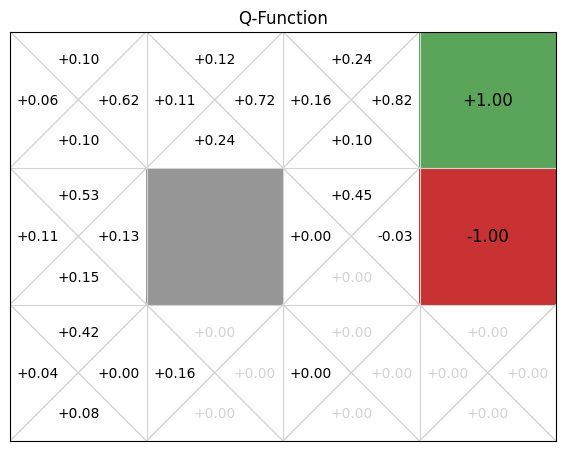

In [7]:
gridworld = GridWorld()
qfunction = QTable()
QLearning(gridworld, EpsilonGreedy(), qfunction).execute(episodes=100)
gridworld.visualise_q_function(qfunction, "Q-Function", grid_size=1.5)

In [8]:
policy = Qpolicy(qfunction)
gridworld.visualise_policy(policy)

NameError: name 'Qpolicy' is not defined